### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install transformers --quiet --quiet
%pip install xformers --quiet --quiet
%pip install einops --quiet --quiet

### Run Demo

2023-07-19 00:59:20 -- pid-24908  -- Experiment Started
2023-07-19 00:59:20 -- pid-27168  -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:22 -- pid-24376  -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:22 -- pid-24376  -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:22 -- pid-7840   -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:22 -- pid-7052   -- Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:22 -- pid-27168  -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-07-19 00:59:25 -- pid-24376  -- Peeking at Environment 0... (3.16 seconds) (completed)
2023-07-19 00:59:25 -- pid-27168  -- Peeking at Environment 0... (3.1 seconds) (completed)
2023-07-19 00:59:25 -- pid-7840   -- Peeking at Environment 0... (3.13 seconds) (completed)
2023-07-19 00:59:25 -- pid-7052   -- Peeking at Environment 0... (3.15 seconds) (

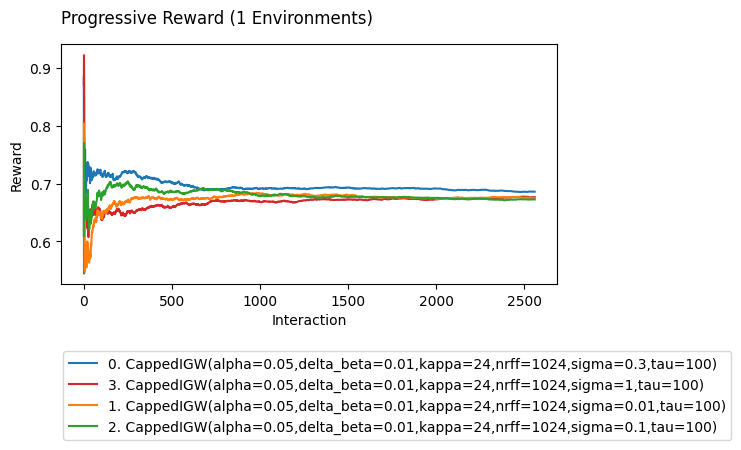

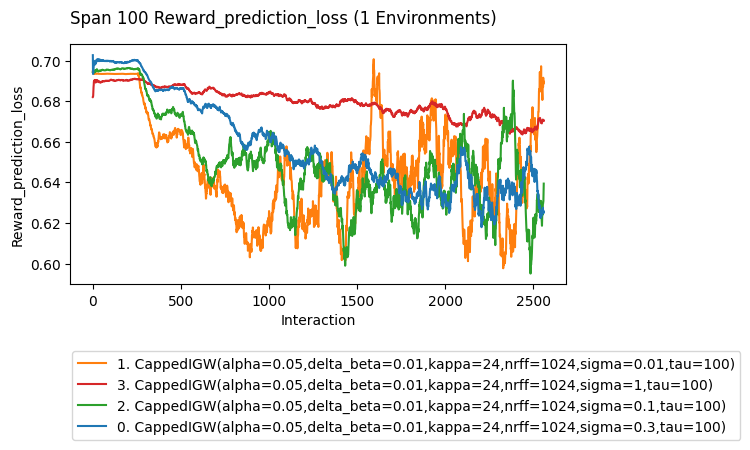

In [1]:
import torch
import coba as cb
from CappedIGW import CappedIGW
from RewardScaler import RewardScaler
from PowerScheduler import PowerScheduler
from MyRewardPredictor import MyRewardPredictor
from UniformReferencePolicy import UniformReferencePolicy

#these values are specific to openml dataset 1187
n_context_dim, n_action_dim = 32, 1
tzero = 100
lr = 1e-2
batch_size = 256

fhats = [MyRewardPredictor(
    numrff=1024,
    sigma=s,
    in_features=n_context_dim+n_action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=PowerScheduler(tzero,-.5))
) for s in [3e-1, 1e-2, 1e-1, 1] ]

cb.Environments.cache_dir('.coba_cache')

env = cb.Environments.from_openml(data_id=1187,take=batch_size*10).scale().filter(RewardScaler()).batch(batch_size)
lrn = [CappedIGW(mu=UniformReferencePolicy(), fhat=fhat, gamma_scheduler = PowerScheduler(tzero,.5))for fhat in fhats]

result = cb.Experiment(env,lrn).run(processes=4)
result.plot_learners()
result.plot_learners(y='reward_prediction_loss', span=100)